In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import glob
import sys

from math import *
import pickle

import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
import torch.optim
from torch.autograd import Variable
from PIL import Image

from IPython import display
import time

import copy

def tovar(x):
    return Variable(torch.FloatTensor(x).cuda(), requires_grad = False)

def toivar(x):
    return Variable(torch.LongTensor(x).cuda(), requires_grad = False)

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.lstm = nn.LSTMCell(4,32)
        self.output = nn.Linear(32,4)
        
        self.h0 = Parameter(torch.FloatTensor(np.random.randn(1,32)))
        self.c0 = Parameter(torch.FloatTensor(np.random.randn(1,32)))
        self.adam = torch.optim.Adam(self.parameters(), lr=1e-2)
        
    def forward(self, x, h, c):        
        h,c = self.lstm(x,(h,c))
        p = F.log_softmax(self.output(c),dim=1)
        
        return h,c,p
    
    def forward_seq(self,x):
        h = self.h0.expand(x.size()[0],32)
        c = self.c0.expand(x.size()[0],32)
        zvec = tovar(np.zeros((x.size()[0],4)))
        
        for i in range(x.size()[2]):
            h,c,p = self.forward(x[:,:,i],h,c)
        
        out = []
        for i in range(x.size()[2]):
            h,c,p = self.forward(zvec,h,c)
            out.append(p.unsqueeze(2))
        
        return torch.cat(out,2)

In [3]:
net = Net().cuda()

In [4]:
def getTask(N):
    data = []
    for i in range(N):
        seq = np.zeros((4,8))
        for j in range(8):
            val = np.random.randint(4)
            seq[val,j] = 1
        
        data.append(seq)
    return np.array(data)

In [5]:
train = getTask(6000)
test = getTask(6000)

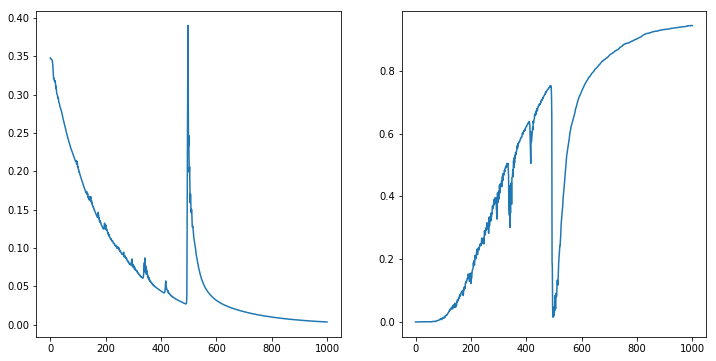

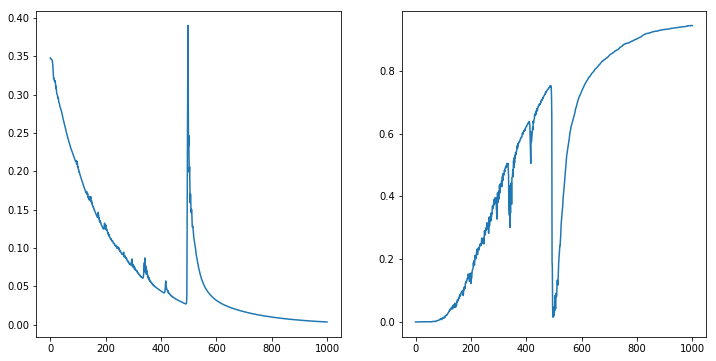

In [6]:
errs = []
accs = []

for epoch in range(1000):
    net.zero_grad()
    p = net.forward_seq(tovar(train))
    loss = -torch.mean(tovar(train)*p)
    loss.backward()
    net.adam.step()
    
    errs.append(loss.cpu().data.numpy()[0])

    p = net.forward_seq(tovar(test)).cpu().data.numpy()
    p = np.argmax(p,axis=1)
    y = np.argmax(test,axis=1)
    mistakes = np.sum(y!=p,axis=1)

    acc = np.mean(mistakes==0)
    accs.append(acc)
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(errs)
    plt.subplot(1,2,2)
    plt.plot(accs)
    plt.gcf().set_size_inches((12,6))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

In [7]:
accs[-1]

0.9436666666666667